In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Inputs
home_price = 600000  # Home purchase price in $
interest_rate = 7.125 / 100  # Annual interest rate as a decimal
loan_term_years = 30  # Loan term in years
down_payment_percent = 10 / 100  # Down payment as a percentage

# Appreciation and inflation rates
home_appreciation_rate = 4 / 100  # Original equity curve (4% appreciation)
home_appreciation_rate_lower = 0 / 100  # Lower bound equity curve (0% appreciation)
home_appreciation_rate_upper = 8 / 100  # Upper bound equity curve (8% appreciation)
annual_inflation_rate = 3 / 100  # Annual inflation adjustment

# Property tax and insurance inputs
mill_levy = 6.765 / 100  # Mill Levy as a percentage
property_tax_rate = 0.62 / 100  # Property tax rate as a percentage
insurance_rate = 0.3 / 100  # Insurance rate as a percentage

In [3]:
# Derived values
down_payment = home_price * down_payment_percent
loan_amount = home_price - down_payment
monthly_interest_rate = interest_rate / 12
num_months = loan_term_years * 12


In [4]:
# Mortgage monthly payment calculation
monthly_payment = loan_amount * (monthly_interest_rate * (1 + monthly_interest_rate) ** num_months) / (
    (1 + monthly_interest_rate) ** num_months - 1
)


In [5]:
# Amortization schedule
principal_remaining = loan_amount
amortization_schedule = []

for month in range(1, num_months + 1):
    interest_payment = principal_remaining * monthly_interest_rate
    principal_payment = monthly_payment - interest_payment
    principal_remaining -= principal_payment
    amortization_schedule.append([month, principal_payment, interest_payment, principal_remaining])

amortization_df = pd.DataFrame(amortization_schedule, columns=["Month", "Principal", "Interest", "Remaining Balance"])
amortization_df["Year"] = amortization_df["Month"] / 12


In [6]:
# Property tax and insurance calculations
assessed_value = home_price * mill_levy
annual_property_tax = assessed_value * property_tax_rate
annual_insurance_cost = home_price * insurance_rate

# Adjust property tax and insurance for inflation
property_tax_by_year = [
    annual_property_tax * (1 + annual_inflation_rate) ** year for year in range(loan_term_years)
]
insurance_cost_by_year = [
    annual_insurance_cost * (1 + annual_inflation_rate) ** year for year in range(loan_term_years)
]

# Expand these costs to monthly values
monthly_property_tax = [tax / 12 for tax in property_tax_by_year for _ in range(12)]
monthly_insurance_cost = [insurance / 12 for insurance in insurance_cost_by_year for _ in range(12)]

# Add property tax and insurance to the amortization DataFrame
amortization_df["Property Tax"] = monthly_property_tax[:len(amortization_df)]
amortization_df["Insurance"] = monthly_insurance_cost[:len(amortization_df)]


In [7]:
# Calculate home values and equity for each appreciation rate
home_values = [home_price * (1 + home_appreciation_rate) ** (month / 12) for month in range(1, num_months + 1)]
home_values_lower = [home_price * (1 + home_appreciation_rate_lower) ** (month / 12) for month in range(1, num_months + 1)]
home_values_upper = [home_price * (1 + home_appreciation_rate_upper) ** (month / 12) for month in range(1, num_months + 1)]

equity = [home_value - balance for home_value, balance in zip(home_values, amortization_df["Remaining Balance"])]
equity_lower = [home_value - balance for home_value, balance in zip(home_values_lower, amortization_df["Remaining Balance"])]
equity_upper = [home_value - balance for home_value, balance in zip(home_values_upper, amortization_df["Remaining Balance"])]


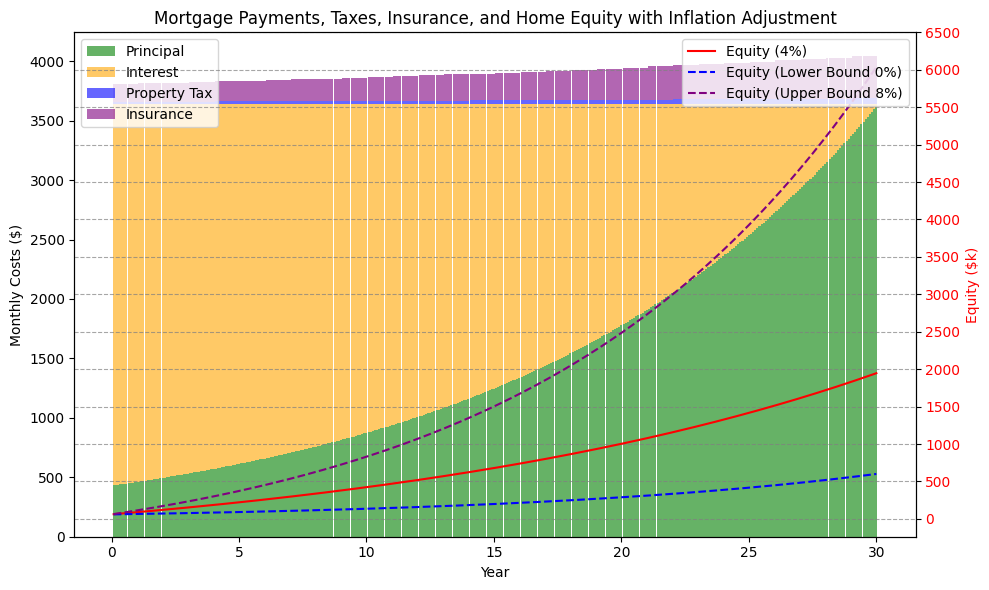

In [14]:
# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Stacked bar chart for Principal, Interest, Property Tax, and Insurance
ax1.bar(amortization_df["Year"], amortization_df["Principal"], label="Principal", alpha=0.6, width=0.08, color="green")
ax1.bar(
    amortization_df["Year"],
    amortization_df["Interest"],
    bottom=amortization_df["Principal"],
    label="Interest",
    alpha=0.6,
    width=0.08,
    color="orange",
)
ax1.bar(
    amortization_df["Year"],
    amortization_df["Property Tax"],
    bottom=amortization_df["Principal"] + amortization_df["Interest"],
    label="Property Tax",
    alpha=0.6,
    width=0.08,
    color="blue",
)
ax1.bar(
    amortization_df["Year"],
    amortization_df["Insurance"],
    bottom=amortization_df["Principal"] + amortization_df["Interest"] + amortization_df["Property Tax"],
    label="Insurance",
    alpha=0.6,
    width=0.08,
    color="purple",
)

ax1.set_xlabel("Year")
ax1.set_ylabel("Monthly Costs ($)")
ax1.set_title("Mortgage Payments, Taxes, Insurance, and Home Equity with Inflation Adjustment")
ax1.legend(loc="upper left")

# Secondary axis for equity with bounds and updated rates
ax2 = ax1.twinx()
ax2.plot(amortization_df["Year"], [e / 1000 for e in equity], label="Equity (4%)", color="red", linestyle='-')
ax2.plot(amortization_df["Year"], [e / 1000 for e in equity_lower], label="Equity (Lower Bound 0%)", color="blue", linestyle='--')
ax2.plot(amortization_df["Year"], [e / 1000 for e in equity_upper], label="Equity (Upper Bound 8%)", color="purple", linestyle='--')
ax2.set_ylabel("Equity ($k)", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Set the secondary y-axis tick locations manually
ax2.set_yticks(range(0, int(max(equity_upper) / 1000) + 500, 500))

# Add horizontal gridlines for the secondary y-axis
ax2.grid(visible=True, which='major', linestyle='--', color='grey', alpha=0.7)

# Add legend for secondary axis
ax2.legend(loc="upper right")

# Save the plot
graph_path = "./mortgage_payments_equity_graph.png"
plt.tight_layout()



### Summary Report of Inputs and Cumulative Totals

In [15]:
# Calculate cumulative totals for the 4 categories
cumulative_principal = amortization_df["Principal"].sum()
cumulative_interest = amortization_df["Interest"].sum()
cumulative_property_tax = amortization_df["Property Tax"].sum()
cumulative_insurance = amortization_df["Insurance"].sum()

# Create a summary of the inputs
summary_inputs = [
    f"Home Price: ${home_price:,.2f}",
    f"Down Payment: ${down_payment:,.2f} ({down_payment_percent * 100:.2f}%)",
    f"Loan Amount: ${loan_amount:,.2f}",
    f"Loan Term: {loan_term_years} years",
    f"Interest Rate: {interest_rate * 100:.2f}%",
    f"Mill Levy: {mill_levy * 100:.2f}%",
    f"Property Tax Rate: {property_tax_rate * 100:.2f}%",
    f"Insurance Rate: {insurance_rate * 100:.2f}%",
    f"Annual Inflation Rate: {annual_inflation_rate * 100:.2f}%",
    f"Home Appreciation Rates: 4% (main), 0% (lower bound), 8% (upper bound)",
]

# Create a summary of the cumulative totals
summary_totals = [
    f"Cumulative Principal Paid: ${cumulative_principal:,.2f}",
    f"Cumulative Interest Paid: ${cumulative_interest:,.2f}",
    f"Cumulative Property Tax Paid: ${cumulative_property_tax:,.2f}",
    f"Cumulative Insurance Paid: ${cumulative_insurance:,.2f}",
    f"Down Payment: ${down_payment:,.2f}",
]

from IPython.display import display, HTML

# Display summary inputs
display(HTML("<h3>Input Summary</h3>"))
for item in summary_inputs:
    display(HTML(f"<p>{item}</p>"))

# Display cumulative totals summary
display(HTML("<h3>Cumulative Totals Summary</h3>"))
for item in summary_totals:
    display(HTML(f"<p>{item}</p>"))

plt.show()
